# Import required libraries

In [1]:
from datetime import datetime
import numpy as np
import pandas as pd

# haven't done any visualizations yet, but might be useful
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch.utils.data import TensorDataset, random_split, DataLoader

from sklearn.metrics import confusion_matrix, classification_report

# custom utility functions
from modules.utils import Utils

# Preliminary Setup

In [2]:
utils = Utils()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Need the mean and std values from training set

In [3]:
df = pd.read_csv('./data/train.csv')

In [4]:
# drop 'id' and 'label' for features
X_df = df.drop(columns=['id', 'label'])

# extract labels separately
y_df = df['label']

print("Number of feature columns:", X_df.shape[1])

Number of feature columns: 500


In [5]:
X_tensor = torch.tensor(X_df.values, dtype=torch.float32)
y_tensor = torch.tensor(y_df, dtype=torch.long)

print(X_tensor.shape)
print(y_tensor.shape)

torch.Size([115406, 500])
torch.Size([115406])


In [6]:
# NORMALIZING WITH MEAN 0 AND UNIT VARIANCE
mean = X_tensor.mean(dim=0, keepdim=True)
std = X_tensor.std(dim=0, unbiased=False, keepdim=True)

# avoid division by zero for constant columns
std[std == 0] = 1.0

X_tensor_norm = (X_tensor - mean) / std

print(X_tensor_norm.shape)
print(X_tensor_norm.mean(dim=0))  # should be ~0
print(X_tensor_norm.std(dim=0))   # should be ~1

torch.Size([115406, 500])
tensor([-6.8555e-08, -4.5615e-08,  1.3685e-08,  2.0196e-08, -1.8378e-08,
        -7.7480e-08, -1.3883e-08, -2.7634e-08, -8.6405e-08, -8.4620e-09,
        -2.9088e-08, -1.9965e-08, -2.1915e-08,  3.9732e-08, -3.6889e-08,
         1.4544e-08,  3.8542e-08,  5.5532e-09,  3.7352e-08,  4.4128e-08,
        -1.9998e-09, -4.4822e-08,  2.4857e-08,  2.0229e-08, -1.3883e-08,
         4.0327e-09,  2.8030e-08,  3.0542e-08,  2.0890e-08, -8.6603e-09,
         2.8890e-08, -1.3288e-08, -3.3848e-08,  4.3500e-08, -1.8048e-08,
        -1.4263e-08,  1.2561e-09,  1.9833e-08, -2.1089e-08, -3.1468e-08,
         2.1287e-08, -9.4701e-09,  1.9833e-09,  1.8709e-08, -3.8277e-08,
         1.9568e-08, -3.9732e-08,  1.9172e-09, -5.5267e-08,  1.5271e-08,
        -7.8670e-09,  2.0031e-08, -6.3465e-09, -2.1485e-09, -8.1645e-09,
         2.6642e-08,  4.7202e-08,  6.0027e-08, -3.1865e-08, -1.6924e-08,
         3.4972e-08, -4.0988e-08, -4.4954e-09, -6.6407e-08,  8.7661e-08,
        -4.4095e-08, -2.3

In [7]:
# total samples
n_samples = len(X_tensor)
n_train = int(0.8 * n_samples)
n_val = n_samples - n_train

# combine into a dataset
dataset = TensorDataset(X_tensor_norm, y_tensor)

# random split
utils.set_seed(433)
g = torch.Generator().manual_seed(433)
train_set, val_set = random_split(dataset, [n_train, n_val], generator=g)

print(f"Train samples: {len(train_set)}")
print(f"Validation samples: {len(val_set)}")

Train samples: 92324
Validation samples: 23082


# Option 1: Retrain the model from Random Search to verify Val Acc

In [8]:
# Medium MLP first submission w/modified architecture, gets 0.827 on FULL TRAIN SET
# grad_clip=True, gauss=True, patience=10. HITS 81.05% VAL ACC
params = {'hidden_size': 4096, 'lr': 0.001, 'weight_decay': 0.1, 'batch_size': 512, 'init_type': 'xavier', 'dropout': 0.5, 'noise_std': 0.65, 'num_epochs': 100, 'warmup_epochs': 12}

# Medium MLP second submission w/modified architecture, gets 0.834 on FULL TRAIN SET
# grad_clip=True, gauss=True, patience=10. HITS 81.45% VAL ACC
params = {'hidden_size': 4096, 'lr': 0.005, 'weight_decay': 0.05, 'batch_size': 512, 'init_type': 'xavier', 'dropout': 0.5, 'noise_std': 0.6, 'num_epochs': 100, 'warmup_epochs': 12}

# Medium MLP third submission w/modified architecture, gets 0.839 on FULL TRAIN SET
# grad_clip=True, gauss=True, patience=10. HITS 81.93% VAL ACC
# grad_clip=True, gauss=True, patience=10, label_smoothing=0.15, max_norm=10.0. HITS 82.65% VAL ACC
params = {'hidden_size': 4096, 'lr': 0.005, 'weight_decay': 0.05, 'batch_size': 512, 'init_type': 'xavier', 'dropout': 0.5, 'noise_std': 0.6, 'num_epochs': 125, 'warmup_epochs': 12}

model, train_accs, val_accs, losses, best_val_acc = utils.train_and_validate(
    train_set, val_set, device, params=params, grad_clip=True, gauss=True, log=True, patience=10
)

  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [1/125] | Train Acc: 1.97% | Val Acc: 2.12% | Loss: 4.364784382176841
Epoch [2/125] | Train Acc: 21.29% | Val Acc: 39.32% | Loss: 3.388981940960028
Epoch [3/125] | Train Acc: 34.07% | Val Acc: 47.41% | Loss: 2.9163020414298124
Epoch [4/125] | Train Acc: 41.76% | Val Acc: 51.95% | Loss: 2.685524843577976
Epoch [5/125] | Train Acc: 46.34% | Val Acc: 54.93% | Loss: 2.5500038021240194
Epoch [6/125] | Train Acc: 49.74% | Val Acc: 57.60% | Loss: 2.4480302714169384
Epoch [7/125] | Train Acc: 52.87% | Val Acc: 59.51% | Loss: 2.3593630921070594
Epoch [8/125] | Train Acc: 55.84% | Val Acc: 60.96% | Loss: 2.2769150534378975
Epoch [9/125] | Train Acc: 58.53% | Val Acc: 62.79% | Loss: 2.1966774172667414
Epoch [10/125] | Train Acc: 61.67% | Val Acc: 64.30% | Loss: 2.1155038865185567
Epoch [11/125] | Train Acc: 64.37% | Val Acc: 65.71% | Loss: 2.0449028108620024
Epoch [12/125] | Train Acc: 66.83% | Val Acc: 66.92% | Loss: 1.9789001054570836
Epoch [13/125] | Train Acc: 68.32% | Val Acc: 67.41% |

### Save the model

In [9]:
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
utils.save_checkpoint(model, params, f'./models/MediumMLP-model-ckpt-{timestamp}.pth', train_accs=train_accs, val_accs=val_accs, losses=losses, full_train_dataset=False)

# Option 2: Load the model trained on train/val sets

In [8]:
# path should be ./models/<filename>
path = './models/MediumMLP-model-ckpt-2025-11-26_18-15-19.pth'
model, params, train_accs, val_accs, losses = utils.load_checkpoint(path, device, full_train_dataset=False)

In [9]:
print(losses)

[4.364784382176841, 3.388981940960028, 2.9163020414298124, 2.685524843577976, 2.5500038021240194, 2.4480302714169384, 2.3593630921070594, 2.2769150534378975, 2.1966774172667414, 2.1155038865185567, 2.0449028108620024, 1.9789001054570836, 1.937910286280421, 1.8788119868644215, 1.8234654190862496, 1.7805692712829182, 1.7478653405930646, 1.722763283228648, 1.700363651599118, 1.6830967273793143, 1.6613315967147704, 1.6500745049579053, 1.638155877912981, 1.625184770793757, 1.6140493144970833, 1.609487924148778, 1.6012258297659216, 1.5914011835809194, 1.5819094831518654, 1.5741861253650147, 1.5672751000609175, 1.562142931595351, 1.5570476796504018, 1.547241561742637, 1.5396401189981994, 1.5395206974034168, 1.5321304807009717, 1.522897114616752, 1.5160088577756414, 1.5095334824560875, 1.5052224454317416, 1.4968232599630455, 1.4867383677926078, 1.4841319420407815, 1.4787373723347872, 1.4681349444247827, 1.4662456055777484, 1.4600600772773542, 1.4533877716822237, 1.4476696132637434, 1.440498066

# Starting from here, Analysis / Plotting

# Classification Report

In [32]:
# we want to collect predictions and true labels from validation set
all_preds = []
all_labels = []

# I need the val_loader to evaluate on the val set
val_loader = DataLoader(val_set, batch_size=params["batch_size"], shuffle=False)

model.eval()
with torch.no_grad():
    for X_val, y_val in val_loader:
        X_val = X_val.to(device)
        outputs = model(X_val)

        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y_val.numpy())

# build confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# I messed up and ended up 1-indexing everything else later, so I will commit to 1-indexing classes
labels = list(range(1, 51))
target_names = [str(i) for i in range(1, 51)]
all_labels_shifted = [x + 1 for x in all_labels]
all_preds_shifted  = [x + 1 for x in all_preds]

print(
    classification_report(
        all_labels_shifted,
        all_preds_shifted,
        labels=labels,
        target_names=target_names,
        digits=4
    )
)

              precision    recall  f1-score   support

           1     0.7843    0.8224    0.8029       473
           2     0.8592    0.7947    0.8257       453
           3     0.8674    0.8326    0.8497       448
           4     0.8719    0.8265    0.8486       461
           5     0.7979    0.8389    0.8179       447
           6     0.9459    0.8632    0.9027       446
           7     0.7981    0.7234    0.7589       470
           8     0.7820    0.7785    0.7803       447
           9     0.7351    0.7987    0.7656       462
          10     0.7742    0.7156    0.7437       436
          11     0.8561    0.7577    0.8039       487
          12     0.9275    0.8914    0.9091       488
          13     0.8862    0.8803    0.8832       451
          14     0.9369    0.9043    0.9204       460
          15     0.7860    0.8172    0.8013       454
          16     0.8784    0.7780    0.8252       455
          17     0.8204    0.8096    0.8150       457
          18     0.9234    

In [33]:
report = classification_report(all_labels, all_preds, digits=4, output_dict=True)

precision_list = [report[str(i)]["precision"] for i in range(50)]
recall_list = [report[str(i)]["recall"] for i in range(50)]
f1_score_list = [report[str(i)]["f1-score"] for i in range(50)]
support_list = [report[str(i)]["support"] for i in range(50)]

In [34]:
print(f"Precision List:\n{precision_list}")
print(f"\nRecall List:\n{recall_list}")
print(f"\nF1-Score List:\n{f1_score_list}")
print(f"\nSupport List:\n{support_list}")

Precision List:
[0.7842741935483871, 0.8591885441527446, 0.8674418604651163, 0.8718535469107551, 0.7978723404255319, 0.9459459459459459, 0.7981220657276995, 0.7820224719101123, 0.7350597609561753, 0.7741935483870968, 0.8561484918793504, 0.9275053304904051, 0.8861607142857143, 0.9369369369369369, 0.7860169491525424, 0.8784119106699751, 0.8203991130820399, 0.9234338747099768, 0.9057017543859649, 0.8454746136865342, 0.793939393939394, 0.7584033613445378, 0.7145593869731801, 0.6829268292682927, 0.7137614678899082, 0.8476953907815631, 0.7762863534675615, 0.807920792079208, 0.9112149532710281, 0.7839643652561247, 0.8585365853658536, 0.8340807174887892, 0.8685344827586207, 0.8478747203579419, 0.8285024154589372, 0.8580786026200873, 0.8081023454157783, 0.8436018957345972, 0.7828054298642534, 0.8352941176470589, 0.7314814814814815, 0.8447058823529412, 0.8148148148148148, 0.8279352226720648, 0.7626459143968871, 0.854389721627409, 0.90020366598778, 0.7937743190661478, 0.926605504587156, 0.8739316

# Confusion Matrix Plot

confusion_matrix.png


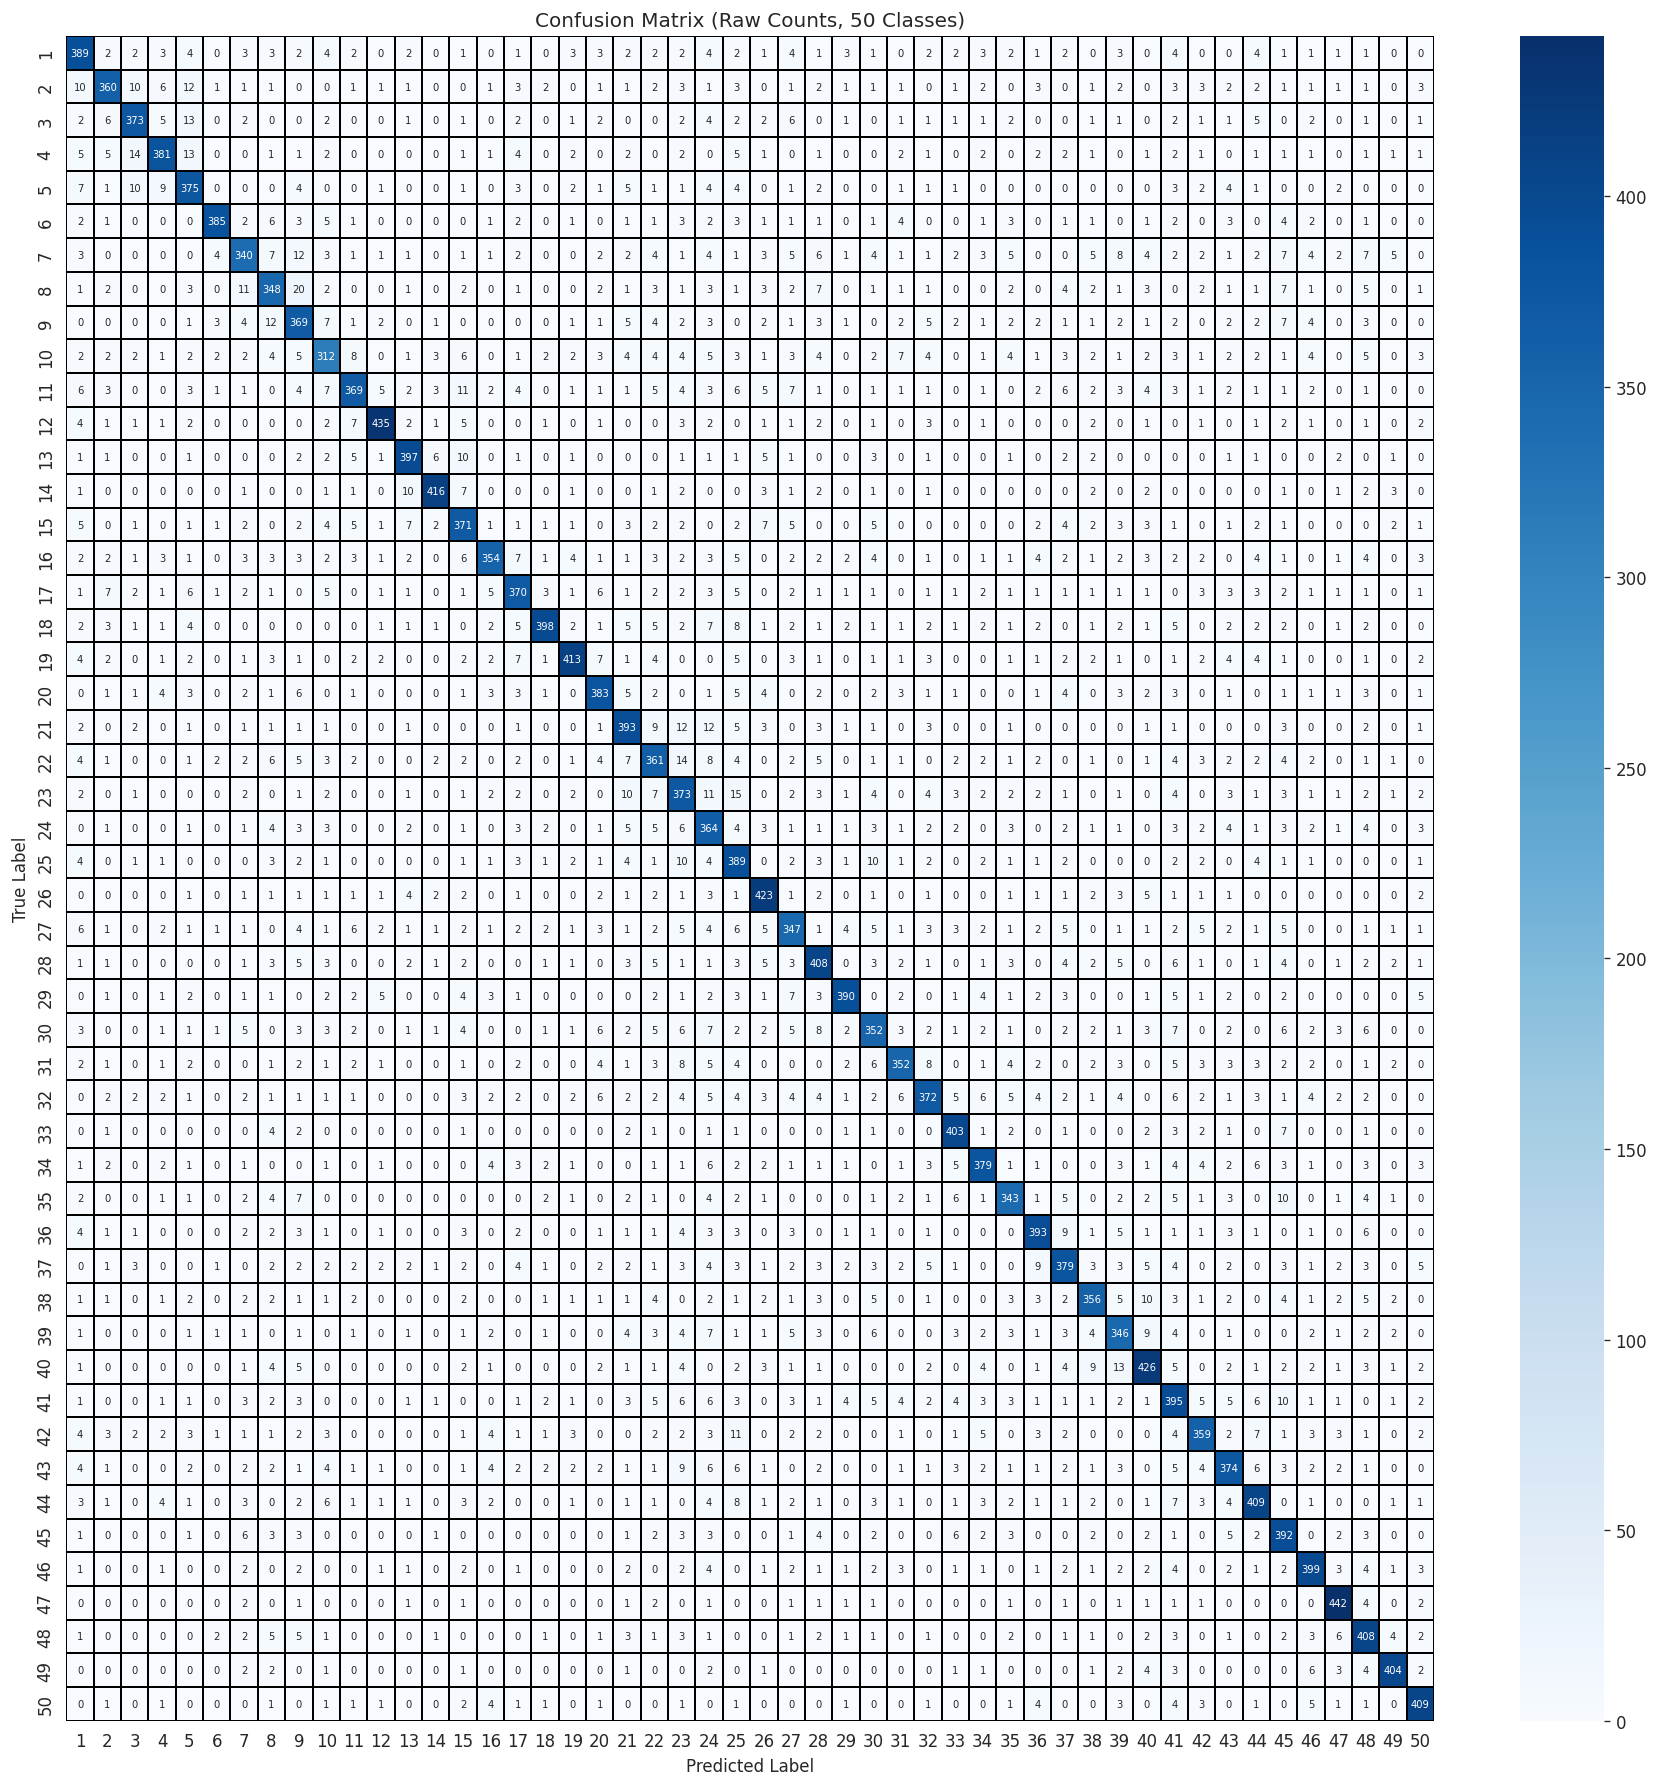

In [35]:
# Class names
classes = [str(i) for i in range(1, 51)]

plt.figure(figsize=(15, 15), dpi=120)
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    linewidths=1,
    linecolor="black",
    xticklabels=classes,
    yticklabels=classes,
    annot_kws={"size": 6}
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Raw Counts, 50 Classes)")
plt.tight_layout()
plt.savefig('./images/confusion_matrix.png')
print('confusion_matrix.png')
plt.show()

# Recall/Precision/F1-Score

metrics_bars.png


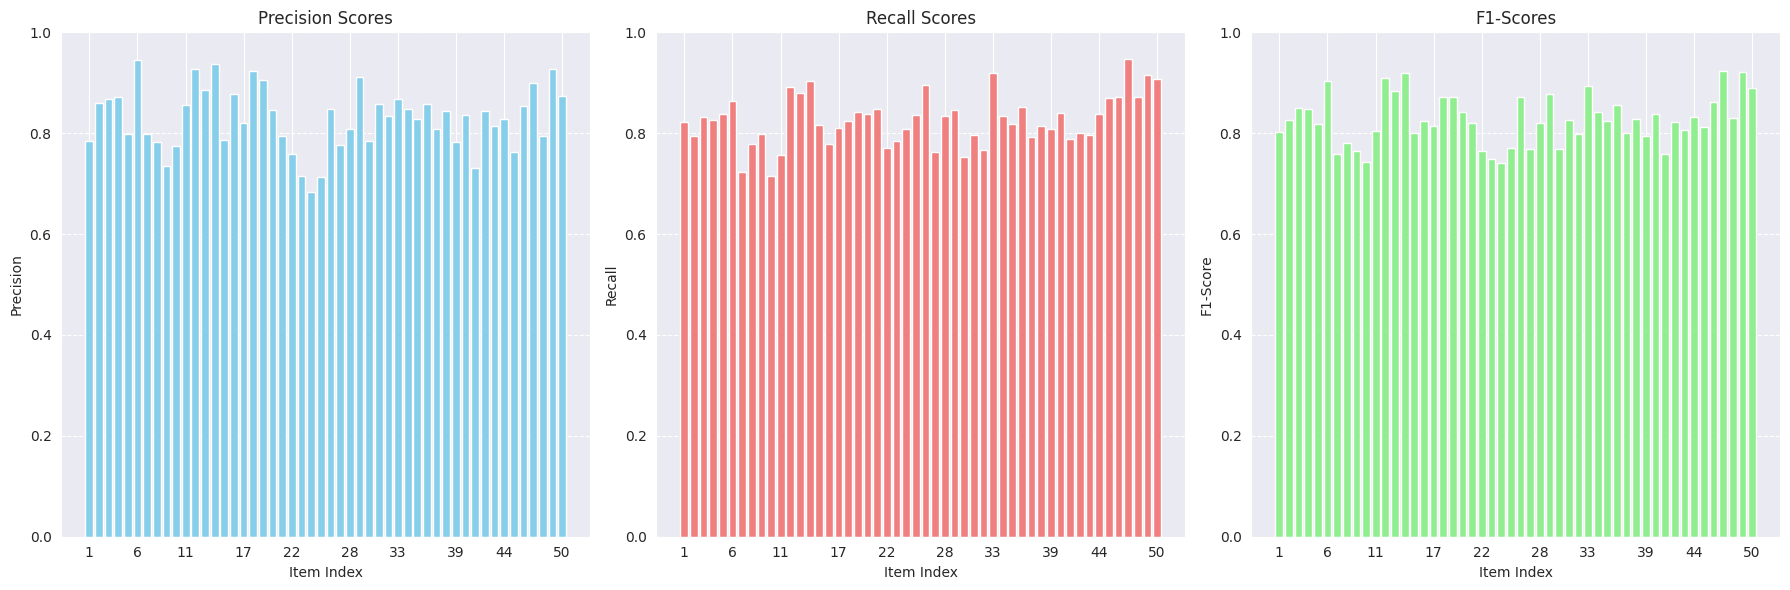

In [13]:
num_items = len(precision_list)
x_index = np.arange(1, num_items + 1)

# Create a figure with 3 subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# Precision subplot
axes[0].bar(x_index, precision_list, color='skyblue')
axes[0].set_title('Precision Scores')
axes[0].set_xlabel('Item Index')
axes[0].set_ylabel('Precision')
axes[0].grid(axis='y', linestyle='--')
axes[0].set_ylim(0, 1)
axes[0].set_xticks(np.linspace(1, num_items, 10, dtype=int))

# Recall subplot
axes[1].bar(x_index, recall_list, color='lightcoral')
axes[1].set_title('Recall Scores')
axes[1].set_xlabel('Item Index')
axes[1].set_ylabel('Recall')
axes[1].grid(axis='y', linestyle='--')
axes[1].set_ylim(0, 1)
axes[1].set_xticks(np.linspace(1, num_items, 10, dtype=int))

# F1-Score subplot
axes[2].bar(x_index, f1_score_list, color='lightgreen')
axes[2].set_title('F1-Scores')
axes[2].set_xlabel('Item Index')
axes[2].set_ylabel('F1-Score')
axes[2].grid(axis='y', linestyle='--')
axes[2].set_ylim(0, 1)
axes[2].set_xticks(np.linspace(1, num_items, 10, dtype=int))

plt.tight_layout()
plt.savefig('./images/metrics_bars.png')
print('metrics_bars.png')
plt.show()

In [13]:
def get_lowest_k(arr, k):
    """Return (sorted_values, sorted_indices) for the lowest-k entries."""
    k = min(k, len(arr))
    idx = np.argsort(arr)[:k]          # k smallest indices
    vals = arr[idx]                    # corresponding values
    order = np.argsort(vals)           # sort the k items by value
    return vals[order], (idx + 1)[order]   # +1 for 1-indexed class numbers

def get_highest_k(arr, k):
    """Return (sorted_values, sorted_indices) for the highest-k entries."""
    k = min(k, len(arr))
    idx = np.argsort(arr)[-k:]         # k biggest indices
    vals = arr[idx]                    # corresponding values
    order = np.argsort(vals)         # sort the k items by value
    return vals[order], (idx + 1)[order]   # +1 for 1-indexed class numbers

In [14]:
k = 10  # how many lowest/highest values to show

# Top-K Lowest Scores

lowest_k_metric_bars.png


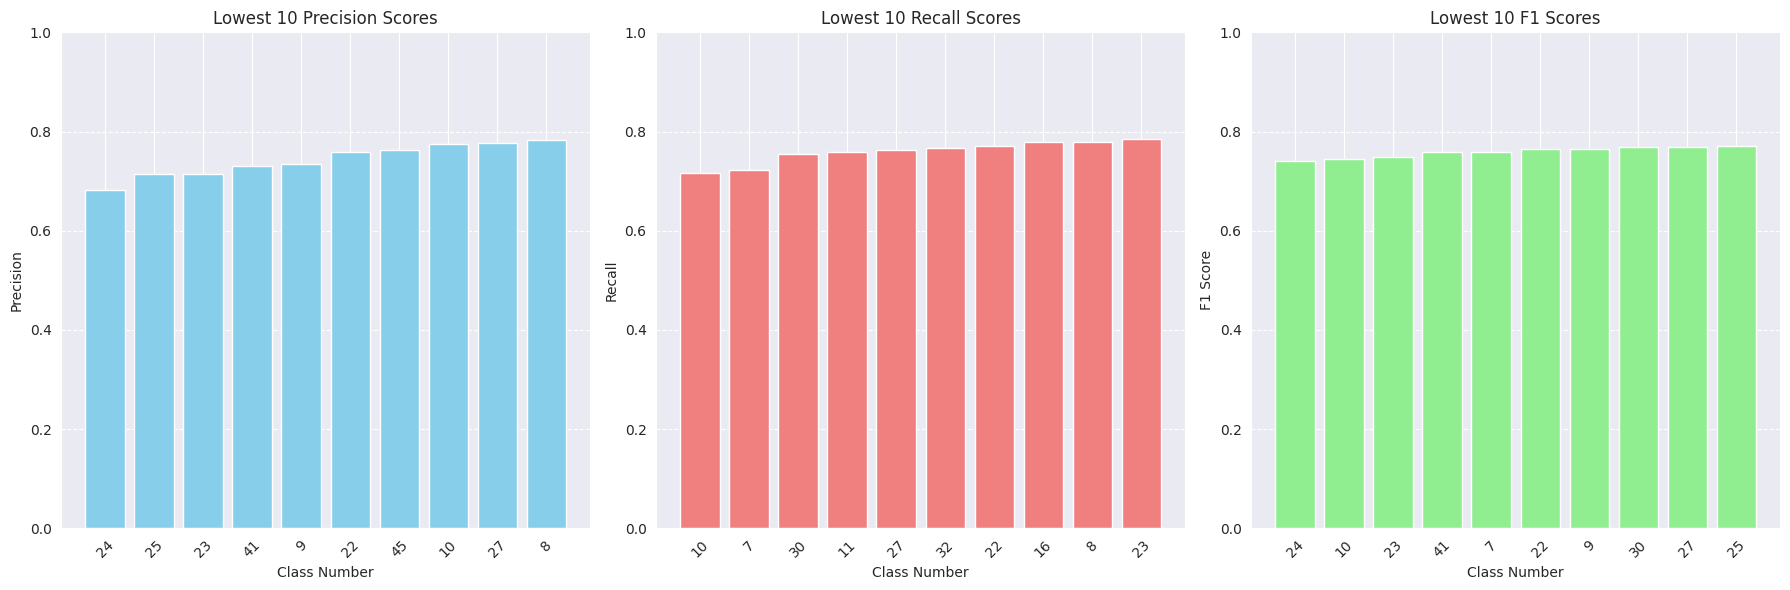

In [15]:
# Convert to numpy arrays
precision_arr = np.array(precision_list)
recall_arr = np.array(recall_list)
f1_arr = np.array(f1_score_list)

# Get sorted lowest-k values + class numbers
prec_vals, prec_classes = get_lowest_k(precision_arr, k)
rec_vals, rec_classes = get_lowest_k(recall_arr, k)
f1_vals, f1_classes = get_lowest_k(f1_arr, k)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Precision subplot
axes[0].bar(range(k), prec_vals, color='skyblue')
axes[0].set_xticks(range(k))
axes[0].set_xticklabels(prec_classes, rotation=45)
axes[0].set_title(f'Lowest {k} Precision Scores')
axes[0].set_xlabel('Class Number')
axes[0].set_ylabel('Precision')
axes[0].set_ylim(0, 1)
axes[0].grid(axis='y', linestyle='--')

# Recall subplot
axes[1].bar(range(k), rec_vals, color='lightcoral')
axes[1].set_xticks(range(k))
axes[1].set_xticklabels(rec_classes, rotation=45)
axes[1].set_title(f'Lowest {k} Recall Scores')
axes[1].set_xlabel('Class Number')
axes[1].set_ylabel('Recall')
axes[1].set_ylim(0, 1)
axes[1].grid(axis='y', linestyle='--')

# F1 subplot
axes[2].bar(range(k), f1_vals, color='lightgreen')
axes[2].set_xticks(range(k))
axes[2].set_xticklabels(f1_classes, rotation=45)
axes[2].set_title(f'Lowest {k} F1 Scores')
axes[2].set_xlabel('Class Number')
axes[2].set_ylabel('F1 Score')
axes[2].set_ylim(0, 1)
axes[2].grid(axis='y', linestyle='--')

plt.tight_layout()
plt.savefig("./images/lowest_k_metric_bars.png")
print("lowest_k_metric_bars.png")
plt.show()

# Top-K Highest Scores

highest_k_metric_bars.png


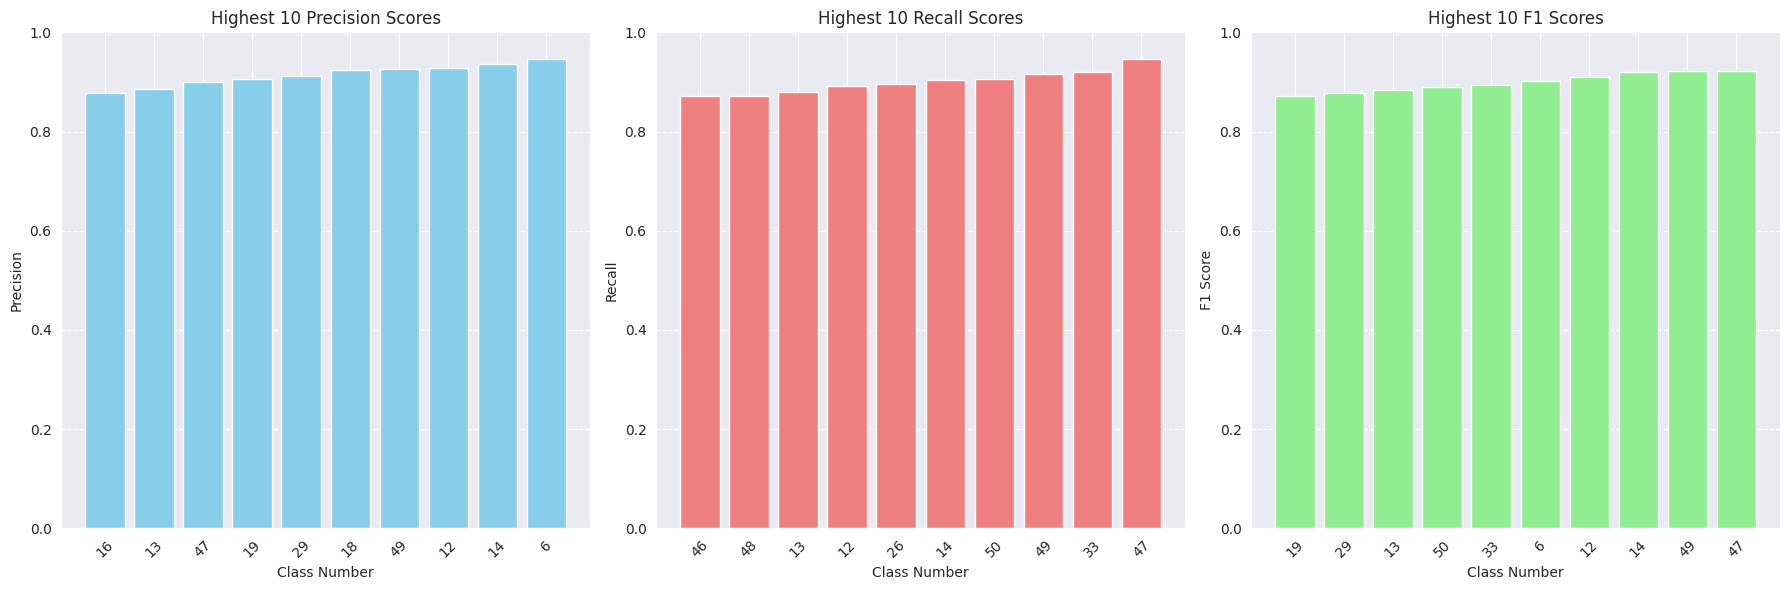

In [16]:
# Get sorted lowest-k values + class numbers
prec_vals, prec_classes = get_highest_k(precision_arr, k)
rec_vals, rec_classes = get_highest_k(recall_arr, k)
f1_vals, f1_classes = get_highest_k(f1_arr, k)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Precision subplot
axes[0].bar(range(k), prec_vals, color='skyblue')
axes[0].set_xticks(range(k))
axes[0].set_xticklabels(prec_classes, rotation=45)
axes[0].set_title(f'Highest {k} Precision Scores')
axes[0].set_xlabel('Class Number')
axes[0].set_ylabel('Precision')
axes[0].set_ylim(0, 1)
axes[0].grid(axis='y', linestyle='--')

# Recall subplot
axes[1].bar(range(k), rec_vals, color='lightcoral')
axes[1].set_xticks(range(k))
axes[1].set_xticklabels(rec_classes, rotation=45)
axes[1].set_title(f'Highest {k} Recall Scores')
axes[1].set_xlabel('Class Number')
axes[1].set_ylabel('Recall')
axes[1].set_ylim(0, 1)
axes[1].grid(axis='y', linestyle='--')

# F1 subplot
axes[2].bar(range(k), f1_vals, color='lightgreen')
axes[2].set_xticks(range(k))
axes[2].set_xticklabels(f1_classes, rotation=45)
axes[2].set_title(f'Highest {k} F1 Scores')
axes[2].set_xlabel('Class Number')
axes[2].set_ylabel('F1 Score')
axes[2].set_ylim(0, 1)
axes[2].grid(axis='y', linestyle='--')

plt.tight_layout()
plt.savefig("./images/highest_k_metric_bars.png")
print("highest_k_metric_bars.png")
plt.show()

# Support Scores

support_bars.png


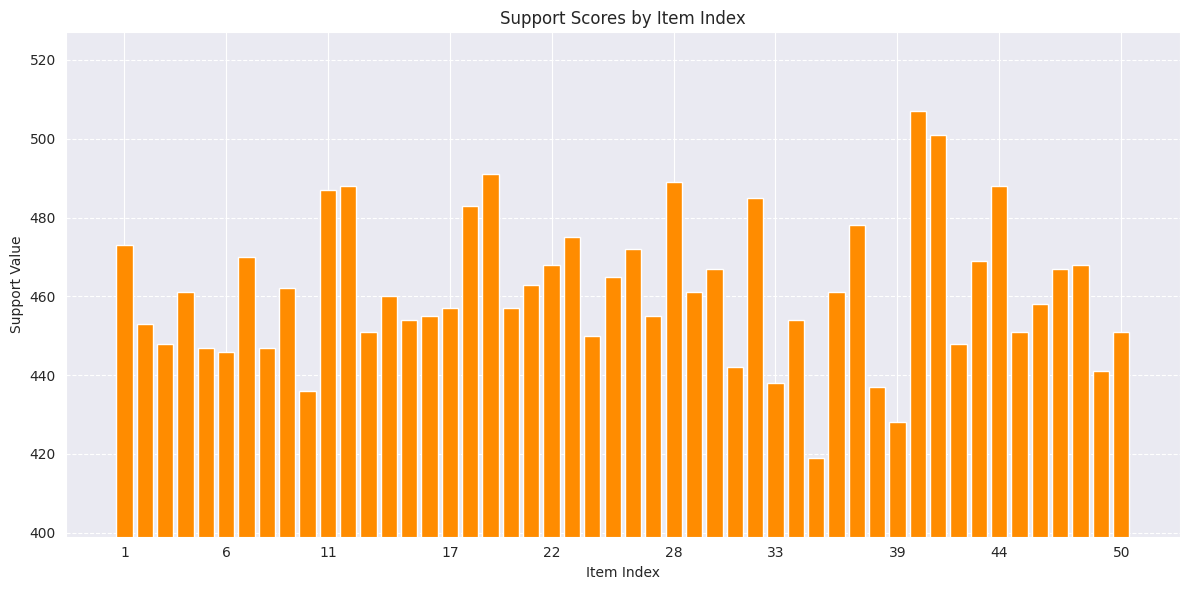

In [17]:
num_items = len(support_list)
x_index = np.arange(1, num_items + 1)

plt.figure(figsize=(12, 6))
plt.bar(x_index, support_list, color='darkorange')
plt.title('Support Scores by Item Index')
plt.xlabel('Item Index')
plt.ylabel('Support Value')
plt.grid(axis='y', linestyle='--')
plt.xticks(np.linspace(1, num_items, 10, dtype=int))

# Adjust y-limit based on the data to focus on the variation
min_val = min(support_list)
max_val = max(support_list)
plt.ylim(min_val - 20, max_val + 20)

plt.tight_layout()
plt.savefig('./images/support_bars.png')
print('support_bars.png')
plt.show()

lowest_k_support_bars.png


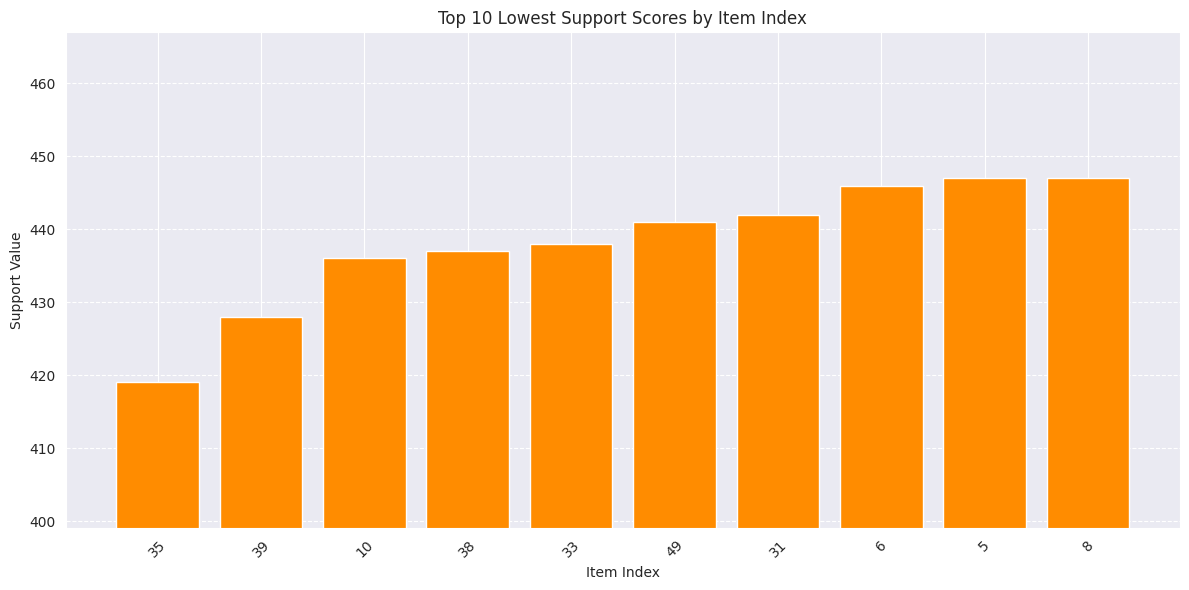

In [18]:
support_arr = np.array(support_list)
support_vals, support_classes = get_lowest_k(support_arr, k)

num_items = len(support_classes)

plt.figure(figsize=(12, 6))
plt.bar(range(k), support_vals, color='darkorange')
plt.title(f'Top {k} Lowest Support Scores by Item Index')
plt.xlabel('Item Index')
plt.xticks(range(k), support_classes, rotation=45)
plt.ylabel('Support Value')
plt.grid(axis='y', linestyle='--')

# Adjust y-limit based on the data to focus on the variation
min_val = min(support_vals)
max_val = max(support_vals)
plt.ylim(min_val - 20, max_val + 20)


plt.tight_layout()
plt.savefig('./images/lowest_k_support_bars.png')
print('lowest_k_support_bars.png')
plt.show()

highest_k_support_bars.png


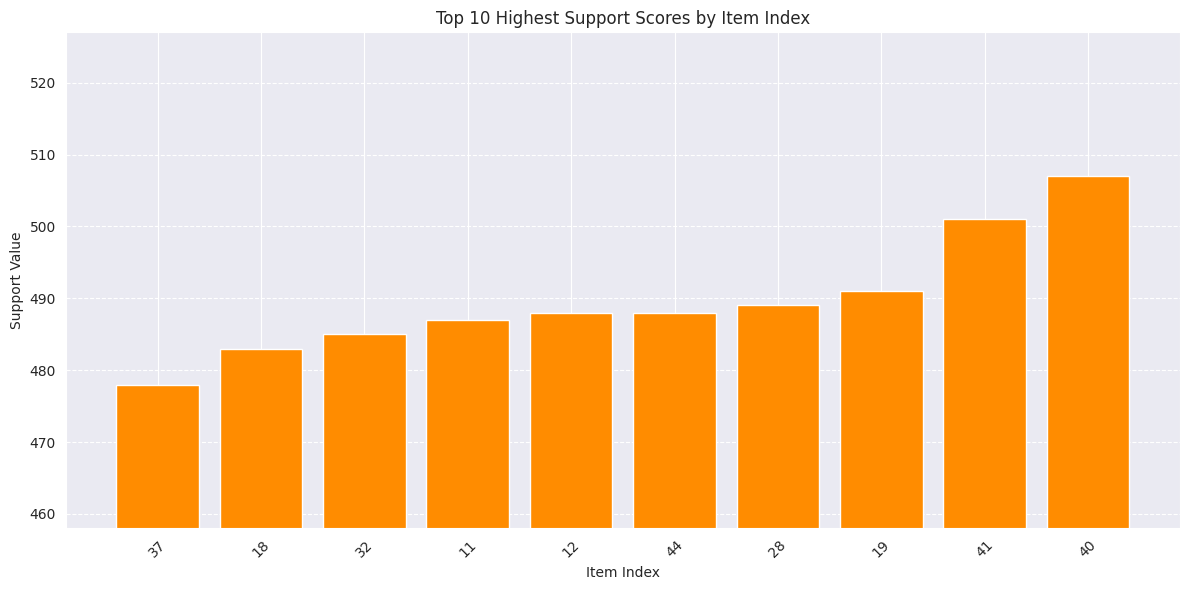

In [19]:
support_arr = np.array(support_list)
support_vals, support_classes = get_highest_k(support_arr, k)

num_items = len(support_classes)

plt.figure(figsize=(12, 6))
plt.bar(range(k), support_vals, color='darkorange')
plt.title(f'Top {k} Highest Support Scores by Item Index')
plt.xlabel('Item Index')
plt.xticks(range(k), support_classes, rotation=45)
plt.ylabel('Support Value')
plt.grid(axis='y', linestyle='--')

# Adjust y-limit based on the data to focus on the variation
min_val = min(support_vals)
max_val = max(support_vals)
plt.ylim(min_val - 20, max_val + 20)


plt.tight_layout()
plt.savefig('./images/highest_k_support_bars.png')
print('highest_k_support_bars.png')
plt.show()

# Average Precision/Recall/F1-Score

In [20]:
avg_precision = np.sum(precision_list) / 50
avg_recall = np.sum(recall_list) / 50
avg_f1_score = np.sum(f1_score_list) / 50

print("Average Precision =", avg_precision)
print("Average Recall =", avg_recall)
print("Average F1-Score =", avg_f1_score)

Average Precision = 0.8293747145122006
Average Recall = 0.8266521316982987
Average F1-Score = 0.827058451516312


# Per-Class Accuracy

In [32]:
per_class_accuracy = cm.diagonal() / cm.sum(axis=1)

for cls_idx, acc in enumerate(per_class_accuracy):
    print(f"Class {cls_idx + 1}: {acc:.4f}")

Class 1: 0.8224
Class 2: 0.7947
Class 3: 0.8326
Class 4: 0.8265
Class 5: 0.8389
Class 6: 0.8632
Class 7: 0.7234
Class 8: 0.7785
Class 9: 0.7987
Class 10: 0.7156
Class 11: 0.7577
Class 12: 0.8914
Class 13: 0.8803
Class 14: 0.9043
Class 15: 0.8172
Class 16: 0.7780
Class 17: 0.8096
Class 18: 0.8240
Class 19: 0.8411
Class 20: 0.8381
Class 21: 0.8488
Class 22: 0.7714
Class 23: 0.7853
Class 24: 0.8089
Class 25: 0.8366
Class 26: 0.8962
Class 27: 0.7626
Class 28: 0.8344
Class 29: 0.8460
Class 30: 0.7537
Class 31: 0.7964
Class 32: 0.7670
Class 33: 0.9201
Class 34: 0.8348
Class 35: 0.8186
Class 36: 0.8525
Class 37: 0.7929
Class 38: 0.8146
Class 39: 0.8084
Class 40: 0.8402
Class 41: 0.7884
Class 42: 0.8013
Class 43: 0.7974
Class 44: 0.8381
Class 45: 0.8692
Class 46: 0.8712
Class 47: 0.9465
Class 48: 0.8718
Class 49: 0.9161
Class 50: 0.9069


class-accuracies.png


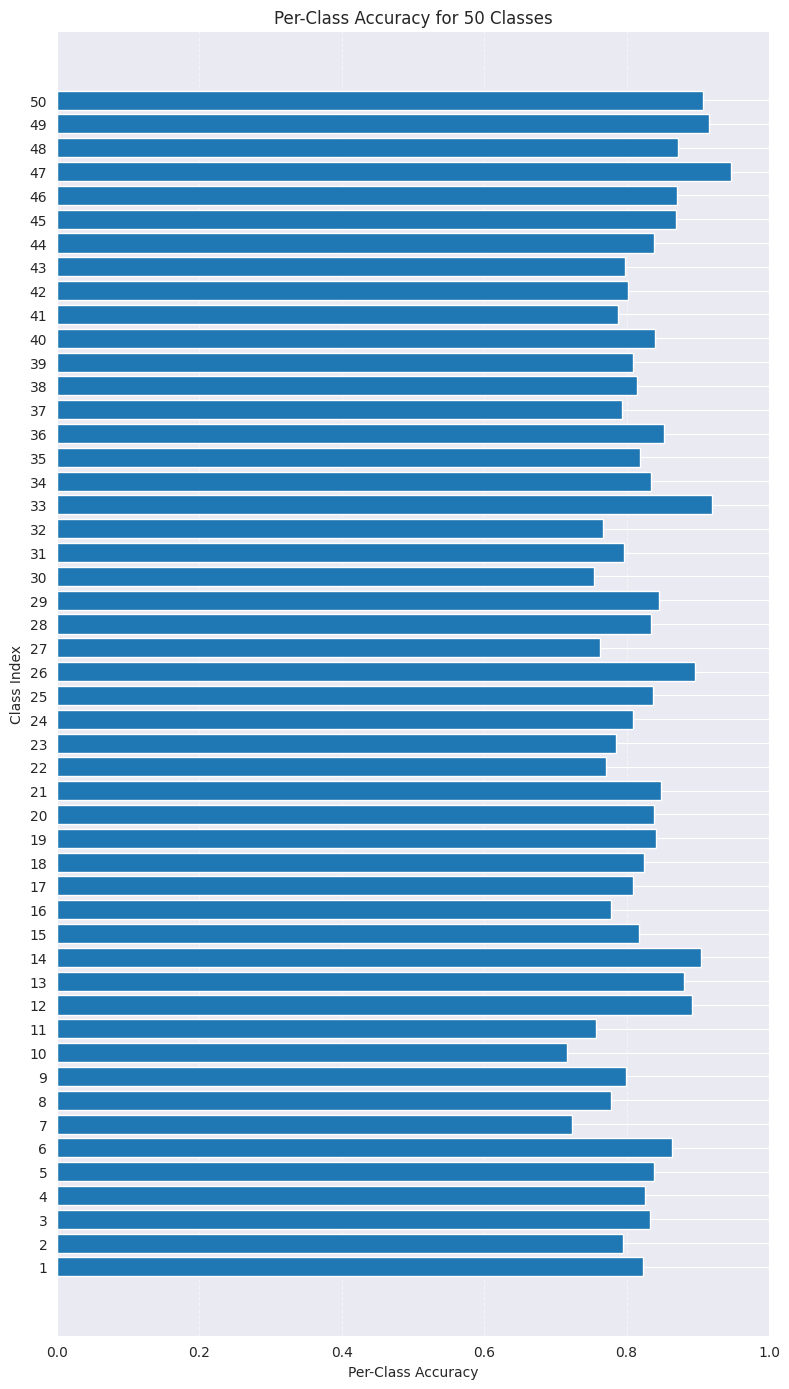

In [31]:
plt.figure(figsize=(8, 14))
plt.barh(np.arange(1, len(per_class_accuracy) + 1), per_class_accuracy)
plt.yticks(np.arange(1, len(per_class_accuracy) + 1), np.arange(1, len(per_class_accuracy) + 1))
plt.xlabel("Per-Class Accuracy")
plt.ylabel("Class Index")
plt.title("Per-Class Accuracy for 50 Classes")
plt.xlim(0, 1)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('./images/class-accuracies.png')
print('class-accuracies.png')
plt.show()

# Train/Val Accuracies

In [21]:
print(f"Train accs:\n{train_accs}")
print(f"\nVal accs:\n{val_accs}")
print(f"\nEpoch Losses:\n{losses}")

Train accs:
[1.9734846843724276, 21.285906156579003, 34.06806464191326, 41.760538971448376, 46.335730687578526, 49.74437849313288, 52.87249252632035, 55.84246783068325, 58.53190936267926, 61.67410424158399, 64.37004462544951, 66.82769377409991, 68.31809713617261, 70.6403535375417, 72.87595858065075, 74.73246393137212, 76.02356916944673, 77.09154716000174, 77.83133313114683, 78.82240804124605, 79.52211775919588, 80.18066808197219, 80.66266626229365, 81.12083531909363, 81.67432086997964, 81.8042979073697, 82.16823361206187, 82.60582297127507, 83.13331311468308, 83.49291625146225, 83.69221437546034, 84.05073437026125, 84.3648455439539, 84.6887049954508, 84.95840734803518, 85.11654607685975, 85.31151163294484, 85.67111476972401, 86.01230449287293, 86.3719076296521, 86.55387548199818, 86.86040466184308, 87.34890169403405, 87.41605649668558, 87.66626229366145, 88.06377539967939, 88.28798578917724, 88.45695593778433, 88.79272995104198, 89.0548503097786, 89.25523157575495, 89.75347688575019, 8

train_val_accs.png


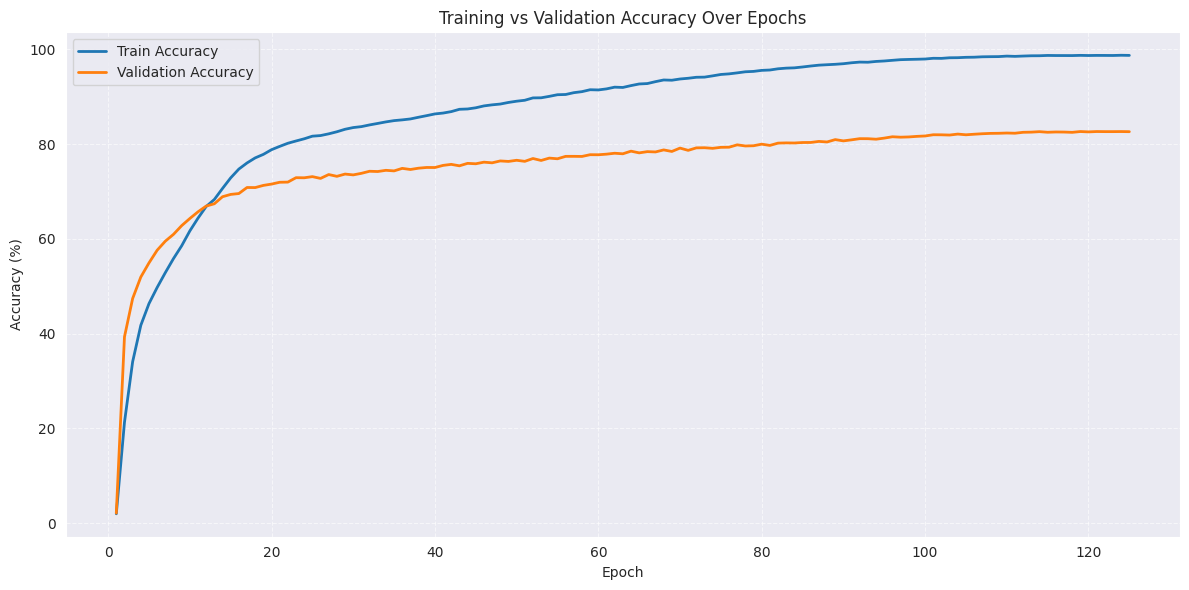

In [22]:
# Convert to numpy arrays
train_accs = np.array(train_accs)
val_accs   = np.array(val_accs)

epochs = np.arange(1, len(train_accs) + 1)

plt.figure(figsize=(12, 6))

plt.plot(epochs, train_accs, label='Train Accuracy', linewidth=2)
plt.plot(epochs, val_accs, label='Validation Accuracy', linewidth=2)

plt.title('Training vs Validation Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')

plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

plt.tight_layout()
plt.savefig('./images/train_val_accs.png')
print('train_val_accs.png')
plt.show()

# Losses over Epochs


Epoch Losses:
[4.364784382176841, 3.388981940960028, 2.9163020414298124, 2.685524843577976, 2.5500038021240194, 2.4480302714169384, 2.3593630921070594, 2.2769150534378975, 2.1966774172667414, 2.1155038865185567, 2.0449028108620024, 1.9789001054570836, 1.937910286280421, 1.8788119868644215, 1.8234654190862496, 1.7805692712829182, 1.7478653405930646, 1.722763283228648, 1.700363651599118, 1.6830967273793143, 1.6613315967147704, 1.6500745049579053, 1.638155877912981, 1.625184770793757, 1.6140493144970833, 1.609487924148778, 1.6012258297659216, 1.5914011835809194, 1.5819094831518654, 1.5741861253650147, 1.5672751000609175, 1.562142931595351, 1.5570476796504018, 1.547241561742637, 1.5396401189981994, 1.5395206974034168, 1.5321304807009717, 1.522897114616752, 1.5160088577756414, 1.5095334824560875, 1.5052224454317416, 1.4968232599630455, 1.4867383677926078, 1.4841319420407815, 1.4787373723347872, 1.4681349444247827, 1.4662456055777484, 1.4600600772773542, 1.4533877716822237, 1.44766961326374

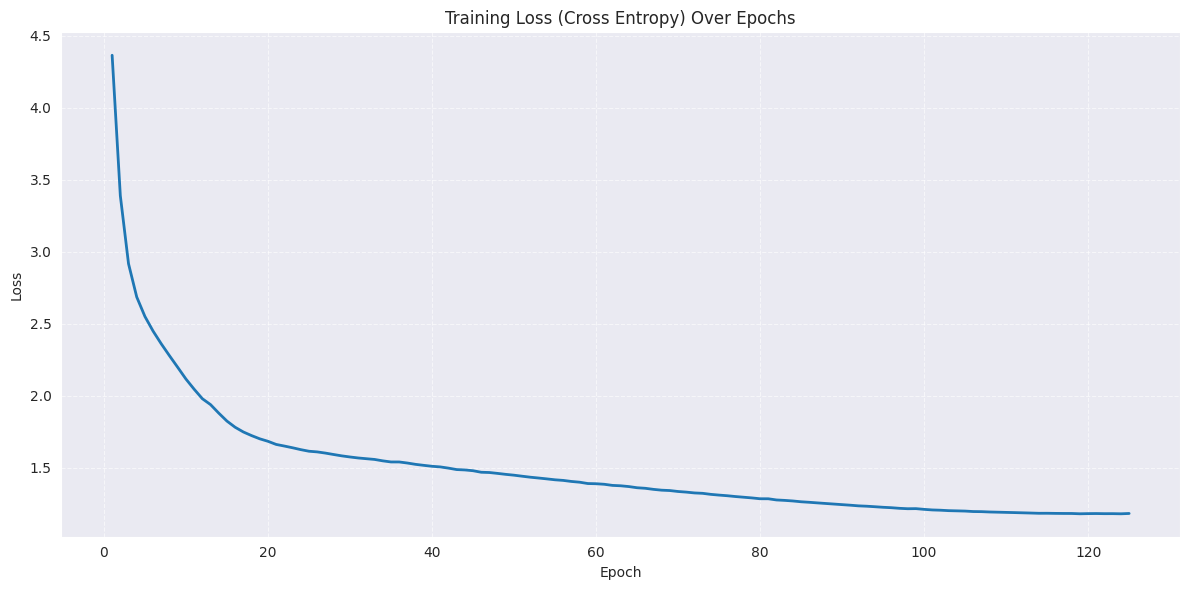

In [23]:
print(f"\nEpoch Losses:\n{losses}")
# Convert to numpy arrays
losses = np.array(losses)
epochs = np.arange(1, len(train_accs) + 1)

plt.figure(figsize=(12, 6))

plt.plot(epochs, losses, linewidth=2)

plt.title('Training Loss (Cross Entropy) Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.savefig('./images/loss.png')
print('loss.png')
plt.show()